In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set(style='ticks', color_codes=True)
sns.set(style='darkgrid')

#Importing the data
credit_df = pd.read_csv("german_credit_data.csv", index_col=0)
credit_ml_df = credit_df.copy() # making a copy of the dataframe for feature engineering and transformation
job_category = ['unskilled and non-resident', 'unskilled and resident', 'skilled', 'highly skilled'] # createing categorial values
credit_ml_df['Job'] = credit_ml_df['Job'].replace([0, 1, 2, 3], job_category) # replacing numerical with categorical values
credit_ml_df.head() #display the first 5 rows

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,skilled,own,NaN,little,1169,6,radio/TV,good
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,bad
2,49,male,unskilled and resident,own,little,NaN,2096,12,education,good
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,good
4,53,male,skilled,free,little,little,4870,24,car,bad


In [42]:
credit_ml_df["Saving accounts"].fillna("none", inplace=True)
credit_ml_df["Checking account"].fillna("none", inplace=True)
credit_ml_df.isna().any()

Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts     False
Checking account    False
Credit amount       False
Duration            False
Purpose             False
Risk                False
dtype: bool

In [43]:
credit_ml_df = pd.get_dummies(credit_ml_df, columns=['Risk'], drop_first=True)
credit_ml_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk_good
0,67,male,skilled,own,none,little,1169,6,radio/TV,1
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,0
2,49,male,unskilled and resident,own,little,none,2096,12,education,1
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,1
4,53,male,skilled,free,little,little,4870,24,car,0


In [44]:
age_interval = (18, 25, 35, 60, 120)
age_cat = ['Student', 'Young', 'Adult', 'Senior']
credit_ml_df["Age Category"] = pd.cut(credit_ml_df.Age, age_interval, labels=age_cat)

credit_interval = (0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000)
credit_cat = ['x < 2500', '2500 <= x < 5000', 
              '5000 <= x < 7500', '7500 <= x < 10000', 
              '10000 <= x < 12500', '12500 <= x < 15000', '15000 <= x < 17500', 'greater than 17500']
credit_ml_df['Credit Category'] = pd.cut(credit_ml_df['Credit amount'], credit_interval, labels=credit_cat)
credit_ml_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk_good,Age Category,Credit Category
0,67,male,skilled,own,none,little,1169,6,radio/TV,1,Senior,x < 2500
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,0,Student,5000 <= x < 7500
2,49,male,unskilled and resident,own,little,none,2096,12,education,1,Adult,x < 2500
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,1,Adult,7500 <= x < 10000
4,53,male,skilled,free,little,little,4870,24,car,0,Adult,2500 <= x < 5000


In [45]:
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(credit_ml_df['Credit Category'], credit_ml_df['Age Category']).style.background_gradient(cmap=cm)

Age Category,Student,Young,Adult,Senior
Credit Category,,,,
x < 2500,114,199,198,26
2500 <= x < 5000,48,127,89,11
5000 <= x < 7500,14,40,43,5
7500 <= x < 10000,7,20,18,1
10000 <= x < 12500,3,8,11,0
12500 <= x < 15000,2,3,6,2
15000 <= x < 17500,2,0,2,0
greater than 17500,0,1,0,0


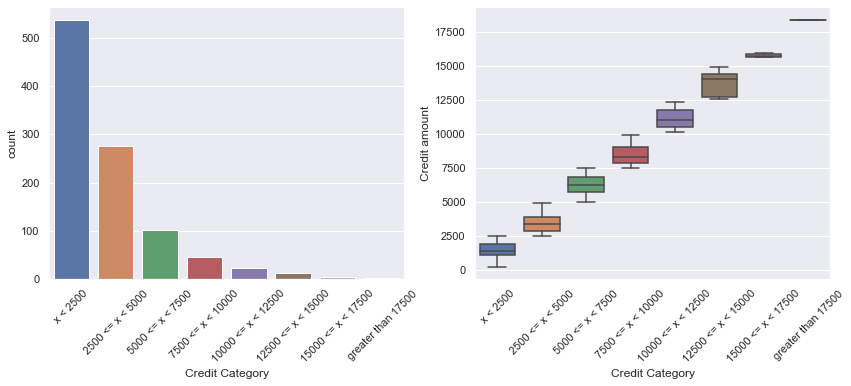

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1 = sns.countplot(data=credit_ml_df, x='Credit Category', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax2 = sns.boxplot(data=credit_ml_df, x='Credit Category', y='Credit amount', ax=ax2)
ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)
plt.show()

In [47]:
credit_cat = credit_ml_df.groupby('Credit Category')
pd.concat([group for (name, group) in credit_cat if name in ['greater than 17500', '15000 <= x < 17500']])

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk_good,Age Category,Credit Category
95,58,male,skilled,rent,little,moderate,15945,54,business,0,Adult,15000 <= x < 17500
637,21,male,skilled,own,little,none,15653,60,radio/TV,1,Student,15000 <= x < 17500
818,43,male,highly skilled,own,little,little,15857,36,vacation/others,1,Adult,15000 <= x < 17500
887,23,male,skilled,own,little,moderate,15672,48,business,0,Student,15000 <= x < 17500
915,32,female,highly skilled,own,little,moderate,18424,48,vacation/others,0,Young,greater than 17500


In [48]:
credit_ml_df = credit_ml_df.drop([95, 637, 818, 887, 915], axis=0)
pd.crosstab(credit_ml_df['Credit Category'], credit_ml_df['Age Category']).style.background_gradient(cmap=cm)

Age Category,Student,Young,Adult,Senior
Credit Category,,,,
x < 2500,114,199,198,26
2500 <= x < 5000,48,127,89,11
5000 <= x < 7500,14,40,43,5
7500 <= x < 10000,7,20,18,1
10000 <= x < 12500,3,8,11,0
12500 <= x < 15000,2,3,6,2


In [49]:
target = credit_ml_df['Risk_good']
credit_ml_df['Credit amount'] = np.log(credit_ml_df['Credit amount'])
credit_ml_df = credit_ml_df.drop(['Risk_good'], axis=1)
credit_ml_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Age Category,Credit Category
0,67,male,skilled,own,none,little,7.063904,6,radio/TV,Senior,x < 2500
1,22,female,skilled,own,little,moderate,8.691315,48,radio/TV,Student,5000 <= x < 7500
2,49,male,unskilled and resident,own,little,none,7.647786,12,education,Adult,x < 2500
3,45,male,skilled,free,little,little,8.972337,42,furniture/equipment,Adult,7500 <= x < 10000
4,53,male,skilled,free,little,little,8.490849,24,car,Adult,2500 <= x < 5000


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(credit_ml_df, target, train_size=0.8, random_state=42)
print("Length of training data:", len(X_train))
print("Length of testing data:", len(X_test))
print("Length of total data:", len(credit_ml_df))

Length of training data: 796
Length of testing data: 199
Length of total data: 995


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
    ('normalizer', Normalizer())
])

num_attributes = ['Age', 'Credit amount', 'Duration']
cat_attributes = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Age Category', 'Credit Category']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])

train_data_prepared = full_pipeline.fit_transform(X_train)
test_data_prepared = full_pipeline.fit_transform(X_test)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', MultinomialNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, train_data_prepared, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

LR: 0.884705 (0.037891)
KNN: 0.864418 (0.037459)
CART: 0.755057 (0.063671)
NB: 0.869568 (0.035005)
RF: 0.867440 (0.057004)
SVM: 0.936292 (0.031395)
XGB: 0.825236 (0.023667)


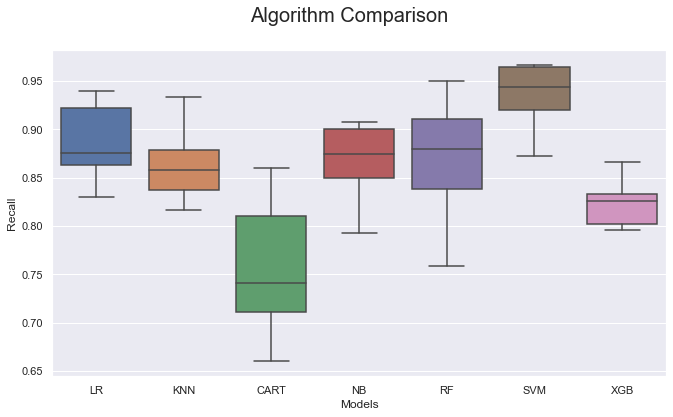

In [53]:
fig, ax1 = plt.subplots(figsize=(11, 6))
fig.suptitle('Algorithm Comparison', fontsize=20)
ax1 = sns.boxplot(data=results)
ax1.set_xticklabels(names)
ax1.set_xlabel("Models")
ax1.set_ylabel("Recall")
plt.show()